# Residualized Spatial Autocorrelation (RSA) Test

We develop a **Residualized Spatial Autocorrelation (RSA)** test to identify whether observed spatial dependence in engagement outcomes reflects genuine geographic structure or is fully accounted for by behavioral information embedded in the predictive model.

Let \( r \in \{1,\dots,R\} \) index geographic regions and let \( Y_r \) denote the total number of clicks observed in region \( r \). Let \( N_r \) be the total number of impressions in region \( r \), and let \( \hat E_r = \sum_{i \in r} \hat p_i \) denote the model-implied expected number of clicks, where \( \hat p_i \) is the predicted click probability for impression \( i \) from the behavioral model.

We estimate Poisson generalized linear models of the form
\[
Y_r \sim \text{Poisson}(\mu_r), \qquad \log \mu_r = \log O_r + \alpha,
\]
where \( O_r \) is an offset. In the **baseline specification**, \( O_r = N_r \), which removes scale effects due to exposure volume but leaves all spatial structure unexplained. In the **behavior-adjusted specification**, \( O_r = \hat E_r \), so that residual variation reflects deviations from the behavioral model’s predictions.

For each specification, we compute **Pearson residuals**
\[
\tilde r_r = \frac{Y_r - \hat \mu_r}{\sqrt{\hat \phi \, \hat \mu_r}},
\]
where \( \hat \phi \) is an estimated dispersion parameter. These residuals form the input to spatial autocorrelation tests.

Spatial dependence is evaluated using **Moran’s I** and **Geary’s C**, constructed with a row-standardized queen-contiguity weight matrix \( W \). Inference is conducted via permutation tests, comparing the observed statistics to their randomization distributions. A significant Moran’s I or Geary’s C in the baseline residuals indicates spatial clustering in outcomes, while attenuation toward their null expectations after behavioral residualization indicates that behavioral predictions absorb spatial dependence.

We complement the statistical tests with maps of regional residuals and their empirical distributions. The RSA test therefore provides a formal diagnostic of whether geographic variation represents independent information or is subsumed by behavioral signals captured by the model.


### County-Level Comparison (Figure 8 and Table 5)

We compare county-level raw CTRs with RSA residuals to assess whether apparent geographical variation persists after conditioning on behavioral model predictions.

Merged impressions: 3162376
After ≥0-impressions/user filter: 3162376
After spatial join: 3059021
3059021
Dispersion φ̂  BEFORE=4.125 | AFTER=0.946
Calibration c BEFORE=0.017519  | AFTER=0.895116


/home/jupyter-hoc_project/.local/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 26, 290.
  warnings.warn(message)


Dropped island polygons: [26, 290]

=== BEFORE  (offset = log N) ===
  Moran's I  = 0.121989 (p=0.00006)  [EI=-0.002331, z=4.128, p_norm=0.00004]
  Geary's C  = 0.890850 (p=0.00094)  [EC=1.000000, z=-3.309, p_norm=0.00047]

=== AFTER   (offset = log E) ===
  Moran's I  = 0.083972 (p=0.00318)  [EI=-0.002331, z=2.866, p_norm=0.00416]
  Geary's C  = 0.900196 (p=0.00162)  [EC=1.000000, z=-3.025, p_norm=0.00124]

=== Summary table (BEFORE vs AFTER) ===
         Model  Regions_used  Islands_dropped  Permutations  Dispersion_phi  Calibration_c  Moran_I  Moran_EI  Moran_z_norm  Moran_p_norm  Moran_p_perm  Geary_C  Geary_EC  Geary_z_norm  Geary_p_norm  Geary_p_perm  Total_Clicks       Total_Imps  Total_Expected
BEFORE (log N)           430                2         99999        4.125039       0.017519 0.121989 -0.002331      4.128169      0.000037      0.000060 0.890850  1.000000     -3.308510      0.000469      0.000940 53,590.000000 3,059,021.000000   59,869.338794
 AFTER (log E)           430

/tmp/ipykernel_464447/2403340817.py:395: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


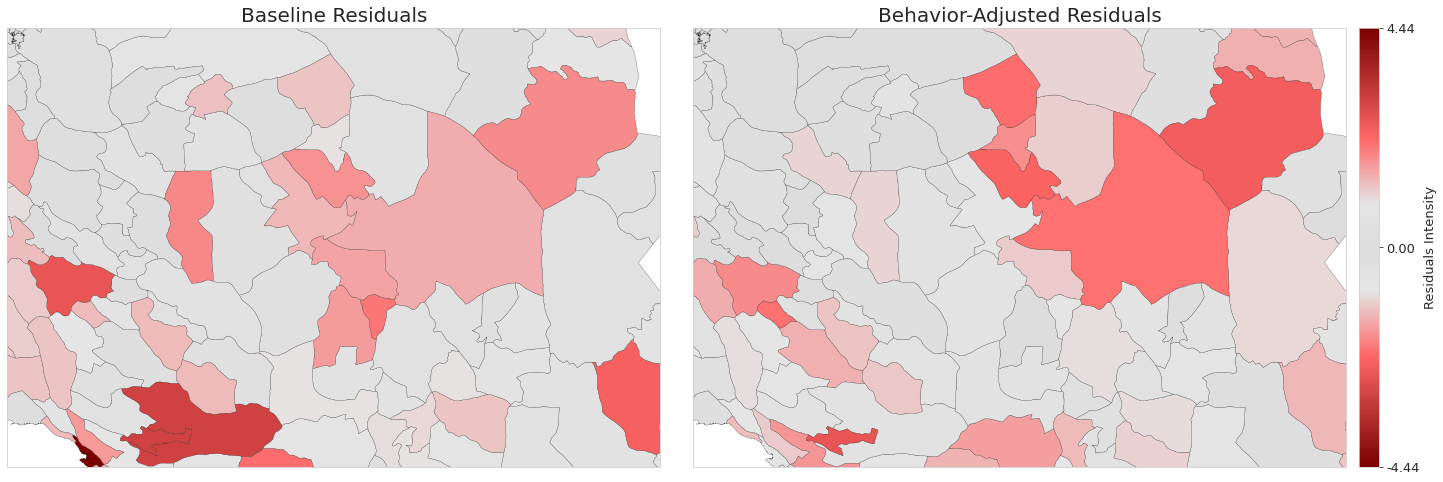

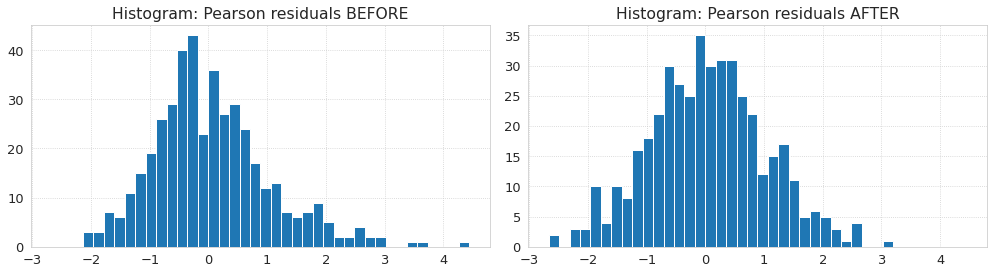

In [10]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from libpysal.weights import Queen
from esda.moran import Moran
from esda.geary import Geary

GEO_FILE   = "geoBoundaries-***-ADM2.geojson"
TEST_FILE  = "preprocessed_test_data.csv"
POLICY_FILE= "policy_evaluation_step_by_step_Behavioral.csv"

MIN_IMPRESSIONS   = 0
MIN_IMPS_PER_USER = 0
PERMUTATIONS      = 99999
SEED              = 7

gdf_polys = gpd.read_file(GEO_FILE).reset_index(drop=True)
if gdf_polys.crs is None:
    gdf_polys = gdf_polys.set_crs("EPSG:4326")
elif gdf_polys.crs.to_string().upper() != "EPSG:4326":
    gdf_polys = gdf_polys.to_crs("EPSG:4326")
gdf_polys["poly_id"] = gdf_polys.index

test_df = pd.read_csv(TEST_FILE, low_memory=False)
pred_df = (pd.read_csv(POLICY_FILE,
                       usecols=["Unique_ID", "Actual_Y", "Predicted_Y"],
                       low_memory=False)
             .drop_duplicates(subset=["Unique_ID"]))

df = (test_df.merge(pred_df, on="Unique_ID", how="inner")
             .dropna(subset=["Actual_Y","Predicted_Y","LONGITUDE","LATITUDE","ANDROID_ID"])
             .copy())
print("Merged impressions:", len(df))

eligible_ids = (df.groupby("ANDROID_ID").size()
                  .loc[lambda s: s > MIN_IMPS_PER_USER].index)
df = df[df["ANDROID_ID"].isin(eligible_ids)].copy()
print(f"After ≥{MIN_IMPS_PER_USER}-impressions/user filter:", len(df))

gdf_points = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df["LONGITUDE"], df["LATITUDE"])],
    crs="EPSG:4326"
)

gdf_joined = gpd.sjoin(gdf_points,
                       gdf_polys[["poly_id","geometry"]],
                       how="left", predicate="within")

if "poly_id_right" in gdf_joined.columns:
    gdf_joined.rename(columns={"poly_id_right":"poly_id"}, inplace=True)
if isinstance(gdf_joined["poly_id"], pd.DataFrame):
    gdf_joined["poly_id"] = gdf_joined["poly_id"].iloc[:,0]

gdf_joined = gdf_joined.dropna(subset=["poly_id"]).copy()
gdf_joined["poly_id"] = gdf_joined["poly_id"].astype(int)
print("After spatial join:", len(gdf_joined))

gdf_joined = gdf_joined.sort_values(["ANDROID_ID", "Unique_ID"]).copy()
gdf_joined["order_idx"] = gdf_joined.groupby("ANDROID_ID").cumcount() + 1
gdf_joined["n_user"]    = gdf_joined.groupby("ANDROID_ID")["Unique_ID"].transform("size")
gdf_joined              = gdf_joined[gdf_joined["order_idx"] > MIN_IMPRESSIONS]

print(len(gdf_joined))

county = (gdf_joined.groupby("poly_id")
                     .agg(clicks=("Actual_Y","sum"),
                          imps=("Actual_Y","size"),
                          exp_clicks=("Predicted_Y","sum"))
                     .reset_index())
county["ctr"] = county["clicks"] / county["imps"].replace(0,np.nan)
county["imps_clip"] = county["imps"].clip(lower=1)
county["exp_clip"]  = county["exp_clicks"].clip(lower=1e-9)

tot_clicks = float(county["clicks"].sum())
tot_imps   = float(county["imps"].sum())
tot_exp    = float(county["exp_clicks"].sum())

def fit_poisson(y, offset_counts):
    X = np.ones((len(y),1))
    model = sm.GLM(y, X, family=sm.families.Poisson(),
                   offset=np.log(np.clip(offset_counts,1e-12,None)))
    res   = model.fit()
    mu    = res.fittedvalues
    phi   = res.pearson_chi2 / max(res.df_resid,1)
    r     = (y - mu) / np.sqrt(phi * np.maximum(mu,1e-12))
    c     = float(np.exp(res.params.iloc[0])) if hasattr(res.params, "iloc") else float(np.exp(res.params[0]))
    return r, float(phi), float(c)

r_before, phi0, c0 = fit_poisson(county["clicks"], county["imps_clip"])
county["pearson_before"] = r_before

r_after , phi1, c1 = fit_poisson(county["clicks"], county["exp_clip"])
county["pearson_after"]  = r_after

print(f"Dispersion φ̂  BEFORE={phi0:.3f} | AFTER={phi1:.3f}")
print(f"Calibration c BEFORE={c0:.6f}  | AFTER={c1:.6f}")

gdf_before = gdf_polys.merge(county[["poly_id","pearson_before"]], on="poly_id", how="left")
gdf_after  = gdf_polys.merge(county[["poly_id","pearson_after"] ], on="poly_id", how="left")

gdf_for_tests = (gdf_before[["poly_id","geometry","pearson_before"]]
                 .merge(gdf_after[["poly_id","pearson_after"]], on="poly_id", how="inner")
                 .dropna().copy())
gdf_for_tests = gdf_for_tests.sort_values("poly_id")
id_order = gdf_for_tests["poly_id"].tolist()

W = Queen.from_dataframe(gdf_for_tests, ids=id_order)
islands = [i for i,nbs in W.neighbors.items() if len(nbs)==0]
if islands:
    gdf_for_tests = gdf_for_tests[~gdf_for_tests["poly_id"].isin(islands)]
    id_order = gdf_for_tests["poly_id"].tolist()
    W = Queen.from_dataframe(gdf_for_tests, ids=id_order)
    print(f"Dropped island polygons: {islands}")
W.transform = "R"

vals_before = gdf_for_tests.set_index("poly_id").loc[id_order,"pearson_before"].to_numpy()
vals_after  = gdf_for_tests.set_index("poly_id").loc[id_order,"pearson_after" ].to_numpy()

moran_before = Moran(vals_before, W, permutations=PERMUTATIONS)
geary_before = Geary(vals_before, W, permutations=PERMUTATIONS)
moran_after  = Moran(vals_after , W, permutations=PERMUTATIONS)
geary_after  = Geary(vals_after , W, permutations=PERMUTATIONS)

n_regions_used = len(id_order)
n_islands_dropped = len(islands)

def report(lbl, m, g):
    print(f"\n=== {lbl} ===")
    print(f"  Moran's I  = {m.I:.6f} (p={m.p_sim:.5f})  [EI={m.EI:.6f}, z={m.z_norm:.3f}, p_norm={m.p_norm:.5f}]")
    print(f"  Geary's C  = {g.C:.6f} (p={g.p_sim:.5f})  [EC={g.EC:.6f}, z={g.z_norm:.3f}, p_norm={g.p_norm:.5f}]")

report("BEFORE  (offset = log N)", moran_before, geary_before)
report("AFTER   (offset = log E)", moran_after,  geary_after)

summary_rows = [
    {
        "Model": "BEFORE (log N)",
        "Regions_used": n_regions_used,
        "Islands_dropped": n_islands_dropped,
        "Permutations": PERMUTATIONS,
        "Dispersion_phi": phi0,
        "Calibration_c": c0,
        "Moran_I": moran_before.I,
        "Moran_EI": moran_before.EI,
        "Moran_z_norm": moran_before.z_norm,
        "Moran_p_norm": moran_before.p_norm,
        "Moran_p_perm": moran_before.p_sim,
        "Geary_C": geary_before.C,
        "Geary_EC": geary_before.EC,
        "Geary_z_norm": geary_before.z_norm,
        "Geary_p_norm": geary_before.p_norm,
        "Geary_p_perm": geary_before.p_sim,
        "Total_Clicks": tot_clicks,
        "Total_Imps": tot_imps,
        "Total_Expected": tot_exp
    },
    {
        "Model": "AFTER (log E)",
        "Regions_used": n_regions_used,
        "Islands_dropped": n_islands_dropped,
        "Permutations": PERMUTATIONS,
        "Dispersion_phi": phi1,
        "Calibration_c": c1,
        "Moran_I": moran_after.I,
        "Moran_EI": moran_after.EI,
        "Moran_z_norm": moran_after.z_norm,
        "Moran_p_norm": moran_after.p_norm,
        "Moran_p_perm": moran_after.p_sim,
        "Geary_C": geary_after.C,
        "Geary_EC": geary_after.EC,
        "Geary_z_norm": geary_after.z_norm,
        "Geary_p_norm": geary_after.p_norm,
        "Geary_p_perm": geary_after.p_sim,
        "Total_Clicks": tot_clicks,
        "Total_Imps": tot_imps,
        "Total_Expected": tot_exp
    }
]

summary = pd.DataFrame(summary_rows, columns=[
    "Model","Regions_used","Islands_dropped","Permutations",
    "Dispersion_phi","Calibration_c",
    "Moran_I","Moran_EI","Moran_z_norm","Moran_p_norm","Moran_p_perm",
    "Geary_C","Geary_EC","Geary_z_norm","Geary_p_norm","Geary_p_perm",
    "Total_Clicks","Total_Imps","Total_Expected"
])

pd.options.display.float_format = "{:,.6f}".format
print("\n=== Summary table (BEFORE vs AFTER) ===")
print(summary.to_string(index=False))

out_csv = "spatial_autocorr_summary_before_after.csv"
print(f"\nSaved summary to: {out_csv}")

def robust_vmax(series_list, q=1):
    vals = pd.concat([s.dropna() for s in series_list], axis=0).to_numpy()
    return np.quantile(np.abs(vals), q) if vals.size else 1.0

vmax = robust_vmax([gdf_before["pearson_before"], gdf_after["pearson_after"]], q=1)
vmin = -vmax

both = pd.concat([gdf_before["pearson_before"].dropna(),
                  gdf_after["pearson_after"].dropna()], axis=0).to_numpy()
linthresh = 5

cmap_bw = LinearSegmentedColormap.from_list(
    "bw_div",
    [(0.0, "red"), (0.5, "#DDDDDD"), (1.0, "blue")]
)

norm = colors.SymLogNorm(linthresh=linthresh, linscale=1.0, vmin=vmin, vmax=vmax, base=10)

def robust_vmax(series_list, q=1):
    vals = pd.concat([s.dropna() for s in series_list], axis=0).to_numpy()
    return np.quantile(np.abs(vals), q) if vals.size else 1.0

vmax = robust_vmax([gdf_before["pearson_before"], gdf_after["pearson_after"]], q=1)

def true_vmin(series_list):
    vals = pd.concat([s.dropna() for s in series_list], axis=0).to_numpy()
    return vals.min() if vals.size else -1.0

vmin = true_vmin([gdf_before["pearson_before"], gdf_after["pearson_after"]])
vmin = -vmax

cmap_plateau = LinearSegmentedColormap.from_list(
    "gray_plateau_div",
    [
        (0.00, "#7A0000"),
        (0.10, "#FF6666"),
        (0.40, "#E5E5E5"),
        (0.50, "#DDDDDD"),
        (0.60, "#E5E5E5"),
        (0.90, "#6FA8FF"),
        (1.00, "#002A69"),
    ]
)

cmap_plateau = LinearSegmentedColormap.from_list(
    "gray_plateau_div",
    [
        (0.00, "#7A0000"),
        (0.25, "#FF6666"),
        (0.40, "#E5E5E5"),
        (0.50, "#DDDDDD"),
        (0.60, "#E5E5E5"),
        (0.75, "#FF6666"),
        (1.00, "#7A0000"),
    ]
)

norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(1, 2, figsize=(24, 12), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.05})
ax0, ax1 = axes

for ax in axes:
    ax.set(xticks=[], yticks=[], aspect="equal")
    ax.set_xlim(51.5, 61.2)
    ax.set_ylim(27.3, 32.8)

gdf_before.plot(column="pearson_before", cmap=cmap_plateau, norm=norm,
                edgecolor="black", linewidth=0.2, legend=False, ax=ax0)
ax0.set_title("Baseline Residuals", fontsize=20)

gdf_after.plot(column="pearson_after", cmap=cmap_plateau, norm=norm,
               edgecolor="black", linewidth=0.2, legend=False, ax=ax1)
ax1.set_title("Behavior-Adjusted Residuals", fontsize=20)

cax = inset_axes(
    ax1,
    width="3%",
    height="100%",
    loc="center left",
    bbox_to_anchor=(1.02, 0., 1, 1),
    bbox_transform=ax1.transAxes,
    borderpad=0,
)

sm = plt.cm.ScalarMappable(cmap=cmap_plateau, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(f"Residuals Intensity")

ticks = np.array([vmin, -max(linthresh, vmax/10), -linthresh, 0, linthresh, max(linthresh, vmax/10), vmax])
ticks = np.unique(np.clip(ticks, vmin, vmax))
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:,.2f}" for t in ticks])
plt.savefig("Fig_Residualized_Map.png")
plt.tight_layout()
plt.show()

both_vals = pd.concat([
    gdf_before["pearson_before"].dropna(),
    gdf_after["pearson_after"].dropna()
], axis=0)
bins = np.histogram_bin_edges(both_vals, bins=40) if both_vals.size else 40

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].hist(gdf_before["pearson_before"].dropna(), bins=bins)
axes[0].set_title("Histogram: Pearson residuals BEFORE")
axes[1].hist(gdf_after["pearson_after"].dropna(),  bins=bins)
axes[1].set_title("Histogram: Pearson residuals AFTER")
plt.tight_layout()
plt.show()

## County-Level Heterogeneity: Sparse vs. Rich Behavioral Histories (Figure 9 and Table 6)

We next examine heterogeneity in spatial dependence as a function of **behavioral history depth**. Using the test data, we partition impressions within each user into **sparse** and **rich** behavioral regimes based on their position in the user’s impression sequence, with the cutoff defined as a fixed fraction (or threshold) of the user’s total impressions.

For each regime, we aggregate impressions to the county level and construct behavior-adjusted outcomes using the predicted click probabilities from the behavioral model. We then estimate Poisson models with offsets equal to the model-implied expected clicks and compute Pearson residuals, which capture deviations from behavioral predictions.

We apply Moran’s I and Geary’s C to these residuals separately for sparse and rich users. Comparing spatial autocorrelation across regimes allows us to test whether geographic dependence persists when behavioral histories are thin and whether it attenuates as behavioral information becomes richer. This analysis clarifies how the role of geography evolves with the accumulation of behavioral data.


Merged impressions: 3162376
After ≥0-impressions/user filter: 3162376


/home/jupyter-hoc_project/.local/lib/python3.9/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


After spatial join: 3162376
3020781
1           2
2           2
4           3
5           3
6           3
           ..
3162371    27
3162372    27
3162373    27
3162374    27
3162375    27
Name: n_user, Length: 3020781, dtype: int64
Split setting: 50%  → group sizes: {'rich': 1526419, 'sparse': 1494362}

=== Running AFTER‑only pipeline for group: SPARSE ===
AFTER stats — φ̂=0.792,  c=0.912451, Totals: clicks=33067, imps=1453576, expected=36239.7


/home/jupyter-hoc_project/.local/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 26, 290.
  warnings.warn(message)


Dropped island polygons: [26, 290]

--- SPARSE :: AFTER (offset = log E) ---
  Moran's I  = 0.069285 (p_perm=0.01190) [EI=-0.002331, z=2.378, p_norm=0.01740]
  Geary's C  = 0.951824 (p_perm=0.07860) [EC=1.000000, z=-1.460, p_norm=0.07211]

=== Running AFTER‑only pipeline for group: RICH ===
AFTER stats — φ̂=1.229,  c=0.852148, Totals: clicks=16698, imps=1483411, expected=19595.2


/home/jupyter-hoc_project/.local/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 26, 290.
  warnings.warn(message)


Dropped island polygons: [26, 290]

--- RICH :: AFTER (offset = log E) ---
  Moran's I  = 0.024627 (p_perm=0.17960) [EI=-0.002336, z=0.893, p_norm=0.37160]
  Geary's C  = 0.975642 (p_perm=0.23310) [EC=1.000000, z=-0.737, p_norm=0.23059]

=== AFTER‑only Summary table (SPARSE vs RICH) ===
 Group  Regions_used  Islands_dropped  Permutations  Dispersion_phi_after  Calibration_c_after  Moran_I_after  Moran_EI_after  Moran_z_norm_after  Moran_p_norm_after  Moran_p_perm_after  Geary_C_after  Geary_EC_after  Geary_z_norm_after  Geary_p_norm_after  Geary_p_perm_after  Total_Clicks       Total_Imps  Total_Expected
SPARSE           430                2          9999              0.792088             0.912451       0.069285       -0.002331            2.378088            0.017403            0.011900       0.951824        1.000000           -1.460283            0.072106            0.078600 33,067.000000 1,453,576.000000   36,239.747552
  RICH           429                2          9999             

/tmp/ipykernel_464447/3761471935.py:395: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


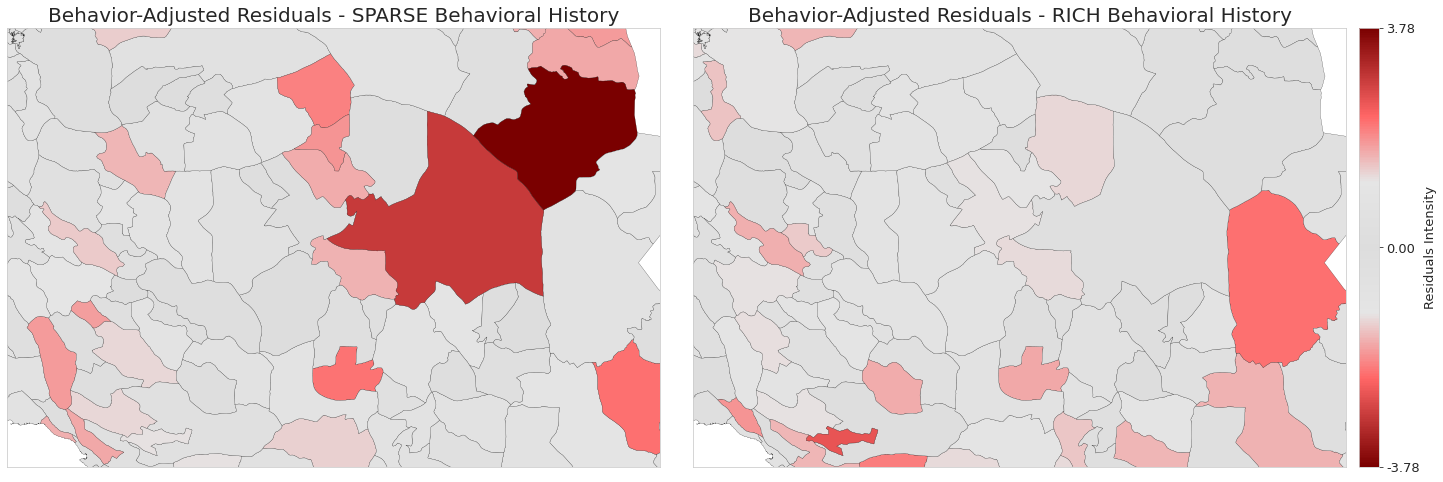

In [11]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import statsmodels.api as sm

from libpysal.weights import Queen
from esda.moran import Moran
from esda.geary import Geary
from matplotlib import colors

GEO_FILE    = "geoBoundaries-***-ADM2.geojson"
TEST_FILE   = "preprocessed_test_data.csv"
POLICY_FILE = "policy_evaluation_step_by_step_Beh3.csv"

MIN_IMPS_PER_USER = 0
MIN_IMPRESSIONS   = 1
PERMUTATIONS      = 9999
SEED              = 7

PCT_SPLIT = 0.5

gdf_polys = gpd.read_file(GEO_FILE).reset_index(drop=True)
if gdf_polys.crs is None:
    gdf_polys = gdf_polys.set_crs("EPSG:4326")
elif gdf_polys.crs.to_string().upper() != "EPSG:4326":
    gdf_polys = gdf_polys.to_crs("EPSG:4326")

gdf_polys["poly_id"] = gdf_polys.index

test_df = pd.read_csv(TEST_FILE, low_memory=False)
pred_df = (
    pd.read_csv(
        POLICY_FILE,
        usecols=["Unique_ID", "Actual_Y", "Predicted_Y"],
        low_memory=False,
    )
    .drop_duplicates(subset=["Unique_ID"])
)

df = (
    test_df.merge(pred_df, on="Unique_ID", how="inner")
    .dropna(subset=["Actual_Y", "Predicted_Y", "LONGITUDE", "LATITUDE", "ANDROID_ID"])
    .copy()
)
print("Merged impressions:", len(df))

eligible_ids = (
    df.groupby("ANDROID_ID")
    .size()
    .loc[lambda s: s > MIN_IMPS_PER_USER]
    .index
)
df = df[df["ANDROID_ID"].isin(eligible_ids)].copy()
print(f"After ≥{MIN_IMPS_PER_USER}-impressions/user filter:", len(df))

gdf_points = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df["LONGITUDE"], df["LATITUDE"])],
    crs="EPSG:4326",
)

gdf_try = gpd.sjoin(
    gdf_points,
    gdf_polys[["poly_id", "geometry"]],
    how="left",
    predicate="within",
)

unmatched = gdf_try["poly_id"].isna()
if unmatched.any():
    gdf_near = gpd.sjoin_nearest(
        gdf_points.loc[unmatched],
        gdf_polys[["poly_id", "geometry"]],
        how="left",
        max_distance=0.05,
        distance_col="dist",
    )
    gdf_try.loc[unmatched, "poly_id"] = gdf_near["poly_id"].values

gdf_joined = gdf_try
gdf_joined["poly_id"] = gdf_joined["poly_id"].astype("Int64")

print("After spatial join:", len(gdf_joined))

gdf_joined = gdf_joined.sort_values(["ANDROID_ID", "Unique_ID"]).copy()
gdf_joined["order_idx"] = gdf_joined.groupby("ANDROID_ID").cumcount() + 1
gdf_joined["n_user"] = gdf_joined.groupby("ANDROID_ID")["Unique_ID"].transform("size")
gdf_joined = gdf_joined[gdf_joined["order_idx"] > MIN_IMPRESSIONS]

print(len(gdf_joined))

cutoff = np.ceil(PCT_SPLIT * gdf_joined["n_user"]).astype(int)
print(cutoff)
cutoff = 25

gdf_joined["density_group"] = np.where(
    gdf_joined["order_idx"] <= cutoff, "sparse", "rich"
)
print(
    f"Split setting: {int(PCT_SPLIT*100)}%  → group sizes:",
    gdf_joined["density_group"].value_counts().to_dict(),
)

def county_aggregate(gdf_subset):
    county = (
        gdf_subset.groupby("poly_id")
        .agg(
            clicks=("Actual_Y", "sum"),
            imps=("Actual_Y", "size"),
            exp_clicks=("Predicted_Y", "sum"),
        )
        .reset_index()
    )
    county["ctr"] = county["clicks"] / county["imps"].replace(0, np.nan)
    county["imps_clip"] = county["imps"].clip(lower=1)
    county["exp_clip"] = county["exp_clicks"].clip(lower=1e-9)
    return county

def fit_poisson_after(y, exp_counts):
    X = np.ones((len(y), 1))
    model = sm.GLM(
        y,
        X,
        family=sm.families.Poisson(),
        offset=np.log(np.clip(exp_counts, 1e-12, None)),
    )
    res = model.fit()
    mu = res.fittedvalues
    phi = float(res.pearson_chi2 / max(res.df_resid, 1))
    r = (y - mu) / np.sqrt(phi * np.maximum(mu, 1e-12))
    c = (
        float(np.exp(res.params.iloc[0]))
        if hasattr(res.params, "iloc")
        else float(np.exp(res.params[0]))
    )
    return r, phi, c

def run_group_pipeline_after(gdf_joined, group_label, perms=PERMUTATIONS):
    print(f"\n=== Running AFTER-only pipeline for group: {group_label.upper()} ===")
    sub = gdf_joined[gdf_joined["density_group"] == group_label].copy()
    if sub.empty:
        raise ValueError(f"No rows for group '{group_label}'.")

    county = county_aggregate(sub)
    tot_clicks = float(county["clicks"].sum())
    tot_imps = float(county["imps"].sum())
    tot_exp = float(county["exp_clicks"].sum())

    r_after, phi_after, c_after = fit_poisson_after(
        county["clicks"], county["exp_clip"]
    )
    county["pearson_after"] = r_after

    print(
        f"AFTER stats — φ̂={phi_after:.3f},  c={c_after:.6f}, "
        f"Totals: clicks={tot_clicks:.0f}, imps={tot_imps:.0f}, expected={tot_exp:.1f}"
    )

    gdf_after = gdf_polys.merge(
        county[["poly_id", "pearson_after"]], on="poly_id", how="left"
    )

    gdf_for_tests = (
        gdf_after[["poly_id", "geometry", "pearson_after"]]
        .dropna()
        .sort_values("poly_id")
        .copy()
    )
    id_order = gdf_for_tests["poly_id"].tolist()

    W = Queen.from_dataframe(gdf_for_tests, ids=id_order)
    islands = [i for i, nbs in W.neighbors.items() if len(nbs) == 0]
    if islands:
        gdf_for_tests = gdf_for_tests[
            ~gdf_for_tests["poly_id"].isin(islands)
        ].copy()
        id_order = gdf_for_tests["poly_id"].tolist()
        W = Queen.from_dataframe(gdf_for_tests, ids=id_order)
        print(f"Dropped island polygons: {islands}")
    W.transform = "R"

    vals_after = (
        gdf_for_tests.set_index("poly_id")
        .loc[id_order, "pearson_after"]
        .to_numpy()
    )

    moran_after = Moran(vals_after, W, permutations=perms)
    geary_after = Geary(vals_after, W, permutations=perms)

    print(f"\n--- {group_label.upper()} :: AFTER (offset = log E) ---")
    print(
        f"  Moran's I  = {moran_after.I:.6f} (p_perm={moran_after.p_sim:.5f}) "
        f"[EI={moran_after.EI:.6f}, z={moran_after.z_norm:.3f}, p_norm={moran_after.p_norm:.5f}]"
    )
    print(
        f"  Geary's C  = {geary_after.C:.6f} (p_perm={geary_after.p_sim:.5f}) "
        f"[EC={geary_after.EC:.6f}, z={geary_after.z_norm:.3f}, p_norm={geary_after.p_norm:.5f}]"
    )

    summary_row = {
        "Group": group_label.upper(),
        "Regions_used": len(id_order),
        "Islands_dropped": len(islands),
        "Permutations": perms,
        "Dispersion_phi_after": phi_after,
        "Calibration_c_after": c_after,
        "Moran_I_after": moran_after.I,
        "Moran_EI_after": moran_after.EI,
        "Moran_z_norm_after": moran_after.z_norm,
        "Moran_p_norm_after": moran_after.p_norm,
        "Moran_p_perm_after": moran_after.p_sim,
        "Geary_C_after": geary_after.C,
        "Geary_EC_after": geary_after.EC,
        "Geary_z_norm_after": geary_after.z_norm,
        "Geary_p_norm_after": geary_after.p_norm,
        "Geary_p_perm_after": geary_after.p_sim,
        "Total_Clicks": tot_clicks,
        "Total_Imps": tot_imps,
        "Total_Expected": tot_exp,
    }

    return {"summary_row": summary_row, "gdf_after": gdf_after}

res_sparse = run_group_pipeline_after(gdf_joined, "sparse", perms=PERMUTATIONS)
res_rich = run_group_pipeline_after(gdf_joined, "rich", perms=PERMUTATIONS)

summary_cols = [
    "Group",
    "Regions_used",
    "Islands_dropped",
    "Permutations",
    "Dispersion_phi_after",
    "Calibration_c_after",
    "Moran_I_after",
    "Moran_EI_after",
    "Moran_z_norm_after",
    "Moran_p_norm_after",
    "Moran_p_perm_after",
    "Geary_C_after",
    "Geary_EC_after",
    "Geary_z_norm_after",
    "Geary_p_norm_after",
    "Geary_p_perm_after",
    "Total_Clicks",
    "Total_Imps",
    "Total_Expected",
]
summary = pd.DataFrame(
    [res_sparse["summary_row"], res_rich["summary_row"]],
    columns=summary_cols,
)

pd.options.display.float_format = "{:,.6f}".format
print("\n=== AFTER-only Summary table (SPARSE vs RICH) ===")
print(summary.to_string(index=False))

from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

gdf_sparse = res_sparse["gdf_after"].copy()
gdf_rich = res_rich["gdf_after"].copy()

def robust_max(series, q=1.0):
    s = series.dropna().to_numpy()
    return np.quantile(np.abs(s), q) if s.size else 1.0

vmax = max(
    robust_max(gdf_sparse["pearson_after"], q=1.0),
    robust_max(gdf_rich["pearson_after"], q=1.0),
)
vmin = -vmax

cmap_plateau = LinearSegmentedColormap.from_list(
    "gray_plateau_div",
    [
        (0.00, "#7A0000"),
        (0.20, "#FF6666"),
        (0.35, "#E5E5E5"),
        (0.50, "#DDDDDD"),
        (0.65, "#E5E5E5"),
        (0.80, "#FF6666"),
        (1.00, "#7A0000"),
    ],
)

norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

fig, axes = plt.subplots(
    1, 2, figsize=(24, 12), gridspec_kw={"width_ratios": [1, 1], "wspace": 0.05}
)
ax0, ax1 = axes

for ax in axes:
    ax.set(xticks=[], yticks=[], aspect="equal")
    ax.set_xlim(51.5, 61.2)
    ax.set_ylim(27.3, 32.8)

gdf_sparse.plot(
    column="pearson_after",
    cmap=cmap_plateau,
    norm=norm,
    edgecolor="black",
    linewidth=0.2,
    legend=False,
    ax=ax0,
)
ax0.set_title(
    "Behavior-Adjusted Residuals - SPARSE Behavioral History", fontsize=20
)

gdf_rich.plot(
    column="pearson_after",
    cmap=cmap_plateau,
    norm=norm,
    edgecolor="black",
    linewidth=0.2,
    legend=False,
    ax=ax1,
)
ax1.set_title(
    "Behavior-Adjusted Residuals - RICH Behavioral History", fontsize=20
)

sm = plt.cm.ScalarMappable(cmap=cmap_plateau, norm=norm)
sm.set_array([])

cax = inset_axes(
    ax1,
    width="3%",
    height="100%",
    loc="center left",
    bbox_to_anchor=(1.02, 0.0, 1, 1),
    bbox_transform=ax1.transAxes,
    borderpad=0,
)

cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Residuals Intensity")

plt.tight_layout()
plt.show()

## City-Level Residualized Spatial Analysis (Table 5)

We replicate the residualized spatial autocorrelation analysis at the **city level** (ADM3), applying the same RSA framework to test whether spatial dependence persists in fine-grained geographic units before and after conditioning on behavioral model predictions.

Merged impressions: 3162376
After ≥0-impressions/user filter: 3162376
After spatial join: 3058603
3058603
Dispersion φ̂  BEFORE=3.718 | AFTER=0.933
Calibration c BEFORE=0.017516  | AFTER=0.895081


/home/jupyter-hoc_project/.local/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 0, 233, 954, 1002.
  warnings.warn(message)
/home/jupyter-hoc_project/.local/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


Dropped island polygons: [0, 233, 954, 1002]

=== BEFORE  (offset = log N) ===
  Moran's I  = 0.055427 (p=0.00242)  [EI=-0.000963, z=2.937, p_norm=0.00332]
  Geary's C  = 0.947775 (p=0.01646)  [EC=1.000000, z=-2.527, p_norm=0.00574]

=== AFTER   (offset = log E) ===
  Moran's I  = -0.000701 (p=0.49156)  [EI=-0.000963, z=0.014, p_norm=0.98909]
  Geary's C  = 0.995801 (p=0.41863)  [EC=1.000000, z=-0.203, p_norm=0.41949]

=== Summary table (BEFORE vs AFTER) ===
         Model  Regions_used  Islands_dropped  Permutations  Dispersion_phi  Calibration_c   Moran_I  Moran_EI  Moran_z_norm  Moran_p_norm  Moran_p_perm  Geary_C  Geary_EC  Geary_z_norm  Geary_p_norm  Geary_p_perm  Total_Clicks       Total_Imps  Total_Expected
BEFORE (log N)          1039                4         99999        3.718293       0.017516  0.055427 -0.000963      2.936889      0.003315      0.002420 0.947775  1.000000     -2.527435      0.005745      0.016460 53,576.000000 3,058,603.000000   59,856.015878
 AFTER (log E) 

/tmp/ipykernel_3443251/4162667152.py:388: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


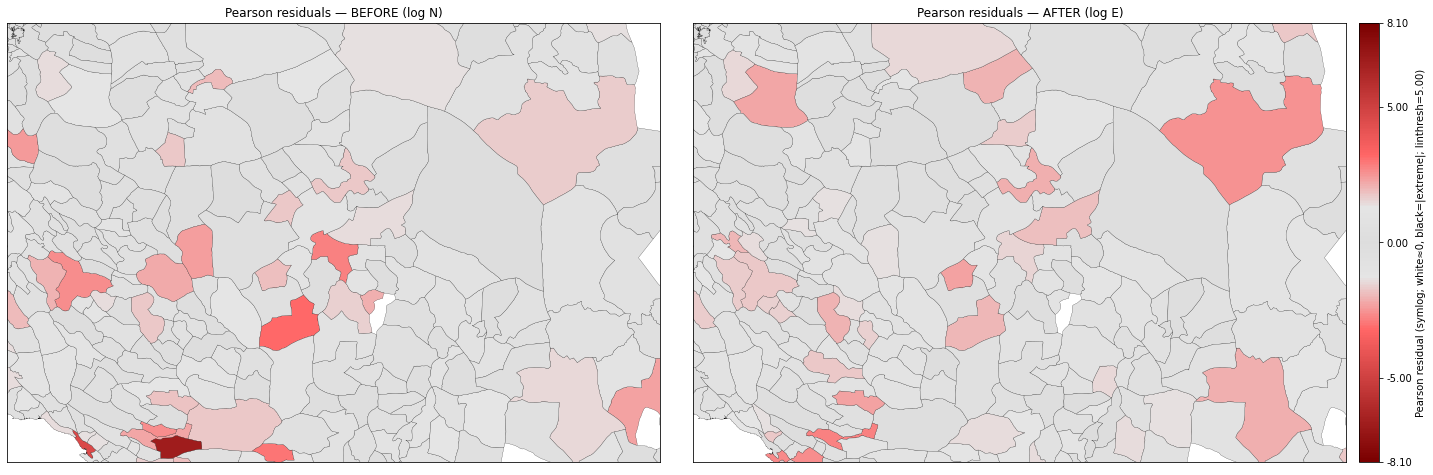

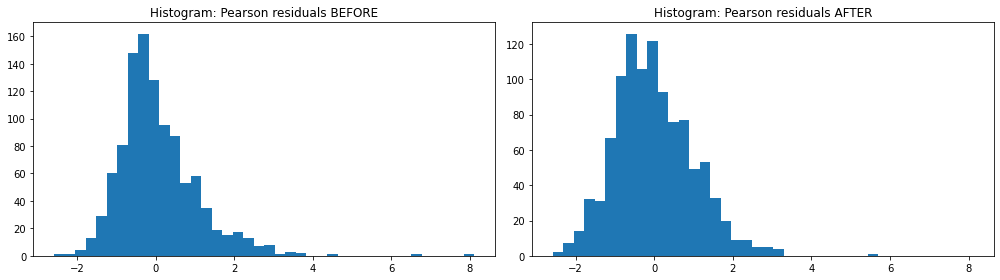

In [106]:
#!/usr/bin/env python3

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import statsmodels.api as sm

from libpysal.weights import Queen
from esda.moran import Moran
from esda.geary import Geary
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

GEO_FILE   = "geoBoundaries-***-ADM3.geojson"
TEST_FILE  = "preprocessed_test_data.csv"
POLICY_FILE= "policy_evaluation_step_by_step_Beh3.csv"

MIN_IMPRESSIONS   = 0
MIN_IMPS_PER_USER = 0
PERMUTATIONS      = 99999
SEED              = 7

gdf_polys = gpd.read_file(GEO_FILE).reset_index(drop=True)
if gdf_polys.crs is None:
    gdf_polys = gdf_polys.set_crs("EPSG:4326")
elif gdf_polys.crs.to_string().upper() != "EPSG:4326":
    gdf_polys = gdf_polys.to_crs("EPSG:4326")
gdf_polys["poly_id"] = gdf_polys.index

test_df = pd.read_csv(TEST_FILE, low_memory=False)
pred_df = (
    pd.read_csv(
        POLICY_FILE,
        usecols=["Unique_ID", "Actual_Y", "Predicted_Y"],
        low_memory=False,
    )
    .drop_duplicates(subset=["Unique_ID"])
)

df = (
    test_df.merge(pred_df, on="Unique_ID", how="inner")
    .dropna(subset=["Actual_Y", "Predicted_Y", "LONGITUDE", "LATITUDE", "ANDROID_ID"])
    .copy()
)
print("Merged impressions:", len(df))

eligible_ids = (
    df.groupby("ANDROID_ID")
    .size()
    .loc[lambda s: s > MIN_IMPS_PER_USER]
    .index
)
df = df[df["ANDROID_ID"].isin(eligible_ids)].copy()
print(f"After ≥{MIN_IMPS_PER_USER}-impressions/user filter:", len(df))

gdf_points = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df["LONGITUDE"], df["LATITUDE"])],
    crs="EPSG:4326",
)

gdf_joined = gpd.sjoin(
    gdf_points,
    gdf_polys[["poly_id", "geometry"]],
    how="left",
    predicate="within",
)

if "poly_id_right" in gdf_joined.columns:
    gdf_joined.rename(columns={"poly_id_right": "poly_id"}, inplace=True)
if isinstance(gdf_joined["poly_id"], pd.DataFrame):
    gdf_joined["poly_id"] = gdf_joined["poly_id"].iloc[:, 0]

gdf_joined = gdf_joined.dropna(subset=["poly_id"]).copy()
gdf_joined["poly_id"] = gdf_joined["poly_id"].astype(int)
print("After spatial join:", len(gdf_joined))

gdf_joined = gdf_joined.sort_values(["ANDROID_ID", "Unique_ID"]).copy()
gdf_joined["order_idx"] = gdf_joined.groupby("ANDROID_ID").cumcount() + 1
gdf_joined["n_user"] = gdf_joined.groupby("ANDROID_ID")["Unique_ID"].transform("size")
gdf_joined = gdf_joined[gdf_joined["order_idx"] > MIN_IMPRESSIONS]

print(len(gdf_joined))

county = (
    gdf_joined.groupby("poly_id")
    .agg(
        clicks=("Actual_Y", "sum"),
        imps=("Actual_Y", "size"),
        exp_clicks=("Predicted_Y", "sum"),
    )
    .reset_index()
)
county["ctr"] = county["clicks"] / county["imps"].replace(0, np.nan)
county["imps_clip"] = county["imps"].clip(lower=1)
county["exp_clip"] = county["exp_clicks"].clip(lower=1e-9)

tot_clicks = float(county["clicks"].sum())
tot_imps = float(county["imps"].sum())
tot_exp = float(county["exp_clicks"].sum())

def fit_poisson(y, offset_counts):
    X = np.ones((len(y), 1))
    model = sm.GLM(
        y,
        X,
        family=sm.families.Poisson(),
        offset=np.log(np.clip(offset_counts, 1e-12, None)),
    )
    res = model.fit()
    mu = res.fittedvalues
    phi = res.pearson_chi2 / max(res.df_resid, 1)
    r = (y - mu) / np.sqrt(phi * np.maximum(mu, 1e-12))
    c = (
        float(np.exp(res.params.iloc[0]))
        if hasattr(res.params, "iloc")
        else float(np.exp(res.params[0]))
    )
    return r, float(phi), float(c)

r_before, phi0, c0 = fit_poisson(county["clicks"], county["imps_clip"])
county["pearson_before"] = r_before

r_after, phi1, c1 = fit_poisson(county["clicks"], county["exp_clip"])
county["pearson_after"] = r_after

print(f"Dispersion φ̂  BEFORE={phi0:.3f} | AFTER={phi1:.3f}")
print(f"Calibration c BEFORE={c0:.6f}  | AFTER={c1:.6f}")

gdf_before = gdf_polys.merge(
    county[["poly_id", "pearson_before"]], on="poly_id", how="left"
)
gdf_after = gdf_polys.merge(
    county[["poly_id", "pearson_after"]], on="poly_id", how="left"
)

gdf_for_tests = (
    gdf_before[["poly_id", "geometry", "pearson_before"]]
    .merge(
        gdf_after[["poly_id", "pearson_after"]],
        on="poly_id",
        how="inner",
    )
    .dropna()
    .copy()
)
gdf_for_tests = gdf_for_tests.sort_values("poly_id")
id_order = gdf_for_tests["poly_id"].tolist()

W = Queen.from_dataframe(gdf_for_tests, ids=id_order)
islands = [i for i, nbs in W.neighbors.items() if len(nbs) == 0]
if islands:
    gdf_for_tests = gdf_for_tests[
        ~gdf_for_tests["poly_id"].isin(islands)
    ]
    id_order = gdf_for_tests["poly_id"].tolist()
    W = Queen.from_dataframe(gdf_for_tests, ids=id_order)
    print(f"Dropped island polygons: {islands}")
W.transform = "R"

vals_before = (
    gdf_for_tests.set_index("poly_id")
    .loc[id_order, "pearson_before"]
    .to_numpy()
)
vals_after = (
    gdf_for_tests.set_index("poly_id")
    .loc[id_order, "pearson_after"]
    .to_numpy()
)

moran_before = Moran(vals_before, W, permutations=PERMUTATIONS)
geary_before = Geary(vals_before, W, permutations=PERMUTATIONS)
moran_after = Moran(vals_after, W, permutations=PERMUTATIONS)
geary_after = Geary(vals_after, W, permutations=PERMUTATIONS)

n_regions_used = len(id_order)
n_islands_dropped = len(islands)

def report(lbl, m, g):
    print(f"\n=== {lbl} ===")
    print(
        f"  Moran's I  = {m.I:.6f} (p={m.p_sim:.5f})  "
        f"[EI={m.EI:.6f}, z={m.z_norm:.3f}, p_norm={m.p_norm:.5f}]"
    )
    print(
        f"  Geary's C  = {g.C:.6f} (p={g.p_sim:.5f})  "
        f"[EC={g.EC:.6f}, z={g.z_norm:.3f}, p_norm={g.p_norm:.5f}]"
    )

report("BEFORE  (offset = log N)", moran_before, geary_before)
report("AFTER   (offset = log E)", moran_after, geary_after)

summary_rows = [
    {
        "Model": "BEFORE (log N)",
        "Regions_used": n_regions_used,
        "Islands_dropped": n_islands_dropped,
        "Permutations": PERMUTATIONS,
        "Dispersion_phi": phi0,
        "Calibration_c": c0,
        "Moran_I": moran_before.I,
        "Moran_EI": moran_before.EI,
        "Moran_z_norm": moran_before.z_norm,
        "Moran_p_norm": moran_before.p_norm,
        "Moran_p_perm": moran_before.p_sim,
        "Geary_C": geary_before.C,
        "Geary_EC": geary_before.EC,
        "Geary_z_norm": geary_before.z_norm,
        "Geary_p_norm": geary_before.p_norm,
        "Geary_p_perm": geary_before.p_sim,
        "Total_Clicks": tot_clicks,
        "Total_Imps": tot_imps,
        "Total_Expected": tot_exp,
    },
    {
        "Model": "AFTER (log E)",
        "Regions_used": n_regions_used,
        "Islands_dropped": n_islands_dropped,
        "Permutations": PERMUTATIONS,
        "Dispersion_phi": phi1,
        "Calibration_c": c1,
        "Moran_I": moran_after.I,
        "Moran_EI": moran_after.EI,
        "Moran_z_norm": moran_after.z_norm,
        "Moran_p_norm": moran_after.p_norm,
        "Moran_p_perm": moran_after.p_sim,
        "Geary_C": geary_after.C,
        "Geary_EC": geary_after.EC,
        "Geary_z_norm": geary_after.z_norm,
        "Geary_p_norm": geary_after.p_norm,
        "Geary_p_perm": geary_after.p_sim,
        "Total_Clicks": tot_clicks,
        "Total_Imps": tot_imps,
        "Total_Expected": tot_exp,
    },
]

summary = pd.DataFrame(
    summary_rows,
    columns=[
        "Model",
        "Regions_used",
        "Islands_dropped",
        "Permutations",
        "Dispersion_phi",
        "Calibration_c",
        "Moran_I",
        "Moran_EI",
        "Moran_z_norm",
        "Moran_p_norm",
        "Moran_p_perm",
        "Geary_C",
        "Geary_EC",
        "Geary_z_norm",
        "Geary_p_norm",
        "Geary_p_perm",
        "Total_Clicks",
        "Total_Imps",
        "Total_Expected",
    ],
)

pd.options.display.float_format = "{:,.6f}".format
print("\n=== Summary table (BEFORE vs AFTER) ===")
print(summary.to_string(index=False))

out_csv = "spatial_autocorr_summary_before_after.csv"
print(f"\nSaved summary to: {out_csv}")

def robust_vmax(series_list, q=1):
    vals = pd.concat([s.dropna() for s in series_list], axis=0).to_numpy()
    return np.quantile(np.abs(vals), q) if vals.size else 1.0

vmax = robust_vmax(
    [gdf_before["pearson_before"], gdf_after["pearson_after"]], q=1
)
vmin = -vmax

linthresh = 5

cmap_plateau = LinearSegmentedColormap.from_list(
    "gray_plateau_div",
    [
        (0.00, "#7A0000"),
        (0.30, "#FF6666"),
        (0.42, "#E5E5E5"),
        (0.50, "#DDDDDD"),
        (0.58, "#E5E5E5"),
        (0.70, "#FF6666"),
        (1.00, "#7A0000"),
    ],
)

norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

fig, axes = plt.subplots(
    1, 2, figsize=(24, 12), gridspec_kw={"width_ratios": [1, 1], "wspace": 0.05}
)
ax0, ax1 = axes

for ax in axes:
    ax.set(xticks=[], yticks=[], aspect="equal")
    ax.set_xlim(51.5, 61.2)
    ax.set_ylim(27.3, 32.8)

gdf_before.plot(
    column="pearson_before",
    cmap=cmap_plateau,
    norm=norm,
    edgecolor="black",
    linewidth=0.2,
    legend=False,
    ax=ax0,
)
ax0.set_title("Pearson residuals — BEFORE (log N)")

gdf_after.plot(
    column="pearson_after",
    cmap=cmap_plateau,
    norm=norm,
    edgecolor="black",
    linewidth=0.2,
    legend=False,
    ax=ax1,
)
ax1.set_title("Pearson residuals — AFTER (log E)")

cax = inset_axes(
    ax1,
    width="3%",
    height="100%",
    loc="center left",
    bbox_to_anchor=(1.02, 0.0, 1, 1),
    bbox_transform=ax1.transAxes,
    borderpad=0,
)

sm = plt.cm.ScalarMappable(cmap=cmap_plateau, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(
    f"Pearson residual (symlog; white≈0, black=|extreme|; linthresh={linthresh:0.2f})"
)

ticks = np.array(
    [
        vmin,
        -max(linthresh, vmax / 10),
        -linthresh,
        0,
        linthresh,
        max(linthresh, vmax / 10),
        vmax,
    ]
)
ticks = np.unique(np.clip(ticks, vmin, vmax))
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:,.2f}" for t in ticks])

plt.tight_layout()
plt.show()

both_vals = pd.concat(
    [
        gdf_before["pearson_before"].dropna(),
        gdf_after["pearson_after"].dropna(),
    ],
    axis=0,
)
bins = np.histogram_bin_edges(both_vals, bins=40) if both_vals.size else 40

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].hist(gdf_before["pearson_before"].dropna(), bins=bins)
axes[0].set_title("Histogram: Pearson residuals BEFORE")
axes[1].hist(gdf_after["pearson_after"].dropna(), bins=bins)
axes[1].set_title("Histogram: Pearson residuals AFTER")
plt.tight_layout()
plt.show()


## City-Level Heterogeneity: Sparse vs. Rich Behavioral Histories (Table 6)

We extend the sparse–rich behavioral history analysis to the **city level**, applying the RSA framework separately to early (sparse) and late (rich) user impressions to assess how spatial dependence evolves with behavioral information at finer geographic granularity.

Merged impressions: 3162376
After ≥0-impressions/user filter: 3162376


/home/jupyter-hoc_project/.local/lib/python3.9/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


After spatial join: 3162376
3020781
1           2
2           2
4           3
5           3
6           3
           ..
3162371    27
3162372    27
3162373    27
3162374    27
3162375    27
Name: n_user, Length: 3020781, dtype: int64
Split setting: 50%  → group sizes: {'rich': 1526419, 'sparse': 1494362}

=== Running AFTER‑only pipeline for group: SPARSE ===
AFTER stats — φ̂=0.782,  c=0.912451, Totals: clicks=33067, imps=1453576, expected=36239.7


/home/jupyter-hoc_project/.local/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 0, 233, 954, 1002.
  warnings.warn(message)
/home/jupyter-hoc_project/.local/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


Dropped island polygons: [0, 233, 954, 1002]

--- SPARSE :: AFTER (offset = log E) ---
  Moran's I  = -0.005265 (p_perm=0.41230) [EI=-0.000964, z=-0.224, p_norm=0.82295]
  Geary's C  = 1.012110 (p_perm=0.28500) [EC=1.000000, z=0.585, p_norm=0.27913]

=== Running AFTER‑only pipeline for group: RICH ===
AFTER stats — φ̂=1.181,  c=0.852148, Totals: clicks=16698, imps=1483411, expected=19595.2


/home/jupyter-hoc_project/.local/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 0, 233, 954, 1002.
  warnings.warn(message)
/home/jupyter-hoc_project/.local/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


Dropped island polygons: [0, 233, 954, 1002]

--- RICH :: AFTER (offset = log E) ---
  Moran's I  = 0.000492 (p_perm=0.45940) [EI=-0.001035, z=0.074, p_norm=0.94117]
  Geary's C  = 1.005985 (p_perm=0.40270) [EC=1.000000, z=0.269, p_norm=0.39403]

=== AFTER‑only Summary table (SPARSE vs RICH) ===
 Group  Regions_used  Islands_dropped  Permutations  Dispersion_phi_after  Calibration_c_after  Moran_I_after  Moran_EI_after  Moran_z_norm_after  Moran_p_norm_after  Moran_p_perm_after  Geary_C_after  Geary_EC_after  Geary_z_norm_after  Geary_p_norm_after  Geary_p_perm_after  Total_Clicks       Total_Imps  Total_Expected
SPARSE          1038                4          9999              0.781845             0.912451      -0.005265       -0.000964           -0.223753            0.822950            0.412300       1.012110        1.000000            0.585429            0.279130            0.285000 33,067.000000 1,453,576.000000   36,239.747552
  RICH           967                4          9999    

/tmp/ipykernel_3443251/1360533353.py:395: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


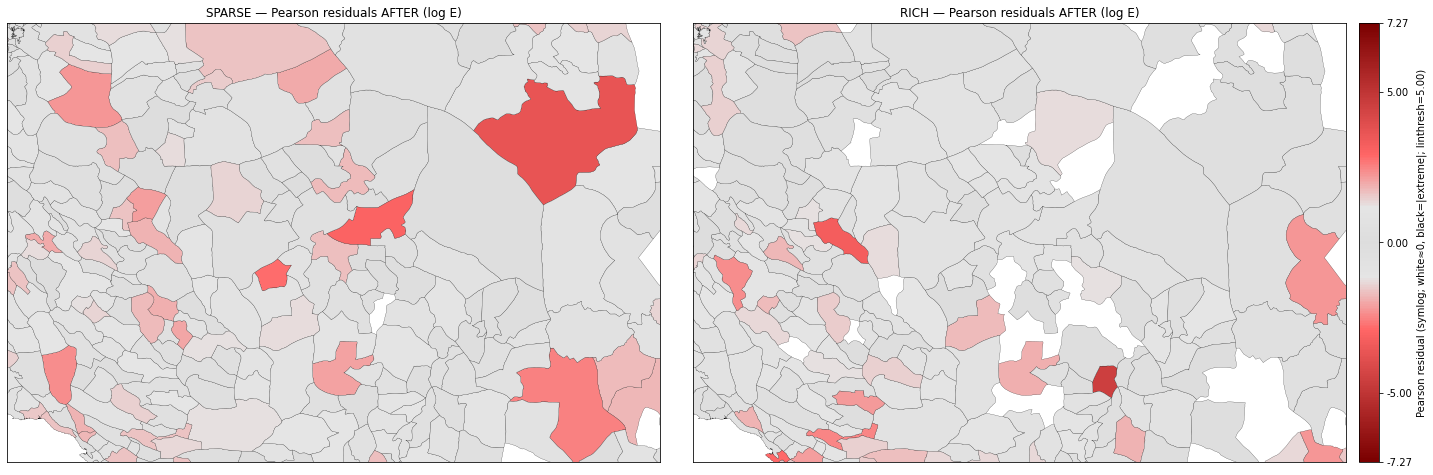

In [107]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import statsmodels.api as sm

from libpysal.weights import Queen
from esda.moran import Moran
from esda.geary import Geary
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

GEO_FILE    = "geoBoundaries-***-ADM3.geojson"
TEST_FILE   = "preprocessed_test_data.csv"
POLICY_FILE = "policy_evaluation_step_by_step_Beh3.csv"

MIN_IMPS_PER_USER = 0
MIN_IMPRESSIONS   = 1
PERMUTATIONS      = 9999
SEED              = 7

PCT_SPLIT = 0.5

gdf_polys = gpd.read_file(GEO_FILE).reset_index(drop=True)
if gdf_polys.crs is None:
    gdf_polys = gdf_polys.set_crs("EPSG:4326")
elif gdf_polys.crs.to_string().upper() != "EPSG:4326":
    gdf_polys = gdf_polys.to_crs("EPSG:4326")
gdf_polys["poly_id"] = gdf_polys.index

test_df = pd.read_csv(TEST_FILE, low_memory=False)
pred_df = (
    pd.read_csv(
        POLICY_FILE,
        usecols=["Unique_ID", "Actual_Y", "Predicted_Y"],
        low_memory=False,
    )
    .drop_duplicates(subset=["Unique_ID"])
)

df = (
    test_df.merge(pred_df, on="Unique_ID", how="inner")
    .dropna(subset=["Actual_Y", "Predicted_Y", "LONGITUDE", "LATITUDE", "ANDROID_ID"])
    .copy()
)
print("Merged impressions:", len(df))

eligible_ids = (
    df.groupby("ANDROID_ID")
    .size()
    .loc[lambda s: s > MIN_IMPS_PER_USER]
    .index
)
df = df[df["ANDROID_ID"].isin(eligible_ids)].copy()
print(f"After ≥{MIN_IMPS_PER_USER}-impressions/user filter:", len(df))

gdf_points = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df["LONGITUDE"], df["LATITUDE"])],
    crs="EPSG:4326",
)

gdf_try = gpd.sjoin(
    gdf_points, gdf_polys[["poly_id", "geometry"]], how="left", predicate="within"
)

unmatched = gdf_try["poly_id"].isna()
if unmatched.any():
    gdf_near = gpd.sjoin_nearest(
        gdf_points.loc[unmatched],
        gdf_polys[["poly_id", "geometry"]],
        how="left",
        max_distance=0.05,
        distance_col="dist",
    )
    gdf_try.loc[unmatched, "poly_id"] = gdf_near["poly_id"].values

gdf_joined = gdf_try
gdf_joined["poly_id"] = gdf_joined["poly_id"].astype("Int64")
print("After spatial join:", len(gdf_joined))

gdf_joined = gdf_joined.sort_values(["ANDROID_ID", "Unique_ID"]).copy()
gdf_joined["order_idx"] = gdf_joined.groupby("ANDROID_ID").cumcount() + 1
gdf_joined["n_user"] = gdf_joined.groupby("ANDROID_ID")["Unique_ID"].transform("size")
gdf_joined = gdf_joined[gdf_joined["order_idx"] > MIN_IMPRESSIONS]

print(len(gdf_joined))

cutoff = np.ceil(PCT_SPLIT * gdf_joined["n_user"]).astype(int)
print(cutoff)
cutoff = 25

gdf_joined["density_group"] = np.where(
    gdf_joined["order_idx"] <= cutoff, "sparse", "rich"
)
print(
    f"Split setting: {int(PCT_SPLIT*100)}%  → group sizes:",
    gdf_joined["density_group"].value_counts().to_dict(),
)

def county_aggregate(gdf_subset):
    county = (
        gdf_subset.groupby("poly_id")
        .agg(
            clicks=("Actual_Y", "sum"),
            imps=("Actual_Y", "size"),
            exp_clicks=("Predicted_Y", "sum"),
        )
        .reset_index()
    )
    county["ctr"] = county["clicks"] / county["imps"].replace(0, np.nan)
    county["imps_clip"] = county["imps"].clip(lower=1)
    county["exp_clip"] = county["exp_clicks"].clip(lower=1e-9)
    return county

def fit_poisson_after(y, exp_counts):
    X = np.ones((len(y), 1))
    model = sm.GLM(
        y,
        X,
        family=sm.families.Poisson(),
        offset=np.log(np.clip(exp_counts, 1e-12, None)),
    )
    res = model.fit()
    mu = res.fittedvalues
    phi = float(res.pearson_chi2 / max(res.df_resid, 1))
    r = (y - mu) / np.sqrt(phi * np.maximum(mu, 1e-12))
    c = (
        float(np.exp(res.params.iloc[0]))
        if hasattr(res.params, "iloc")
        else float(np.exp(res.params[0]))
    )
    return r, phi, c

def run_group_pipeline_after(gdf_joined, group_label, perms=PERMUTATIONS):
    print(f"\n=== Running AFTER-only pipeline for group: {group_label.upper()} ===")
    sub = gdf_joined[gdf_joined["density_group"] == group_label].copy()
    if sub.empty:
        raise ValueError(f"No rows for group '{group_label}'.")

    county = county_aggregate(sub)
    tot_clicks = float(county["clicks"].sum())
    tot_imps = float(county["imps"].sum())
    tot_exp = float(county["exp_clicks"].sum())

    r_after, phi_after, c_after = fit_poisson_after(
        county["clicks"], county["exp_clip"]
    )
    county["pearson_after"] = r_after

    print(
        f"AFTER stats — φ̂={phi_after:.3f},  c={c_after:.6f}, "
        f"Totals: clicks={tot_clicks:.0f}, imps={tot_imps:.0f}, expected={tot_exp:.1f}"
    )

    gdf_after = gdf_polys.merge(
        county[["poly_id", "pearson_after"]], on="poly_id", how="left"
    )

    gdf_for_tests = (
        gdf_after[["poly_id", "geometry", "pearson_after"]]
        .dropna()
        .sort_values("poly_id")
        .copy()
    )
    id_order = gdf_for_tests["poly_id"].tolist()

    W = Queen.from_dataframe(gdf_for_tests, ids=id_order)
    islands = [i for i, nbs in W.neighbors.items() if len(nbs) == 0]
    if islands:
        gdf_for_tests = gdf_for_tests[
            ~gdf_for_tests["poly_id"].isin(islands)
        ].copy()
        id_order = gdf_for_tests["poly_id"].tolist()
        W = Queen.from_dataframe(gdf_for_tests, ids=id_order)
        print(f"Dropped island polygons: {islands}")
    W.transform = "R"

    vals_after = (
        gdf_for_tests.set_index("poly_id")
        .loc[id_order, "pearson_after"]
        .to_numpy()
    )

    moran_after = Moran(vals_after, W, permutations=perms)
    geary_after = Geary(vals_after, W, permutations=perms)

    print(f"\n--- {group_label.upper()} :: AFTER (offset = log E) ---")
    print(
        f"  Moran's I  = {moran_after.I:.6f} (p_perm={moran_after.p_sim:.5f}) "
        f"[EI={moran_after.EI:.6f}, z={moran_after.z_norm:.3f}, p_norm={moran_after.p_norm:.5f}]"
    )
    print(
        f"  Geary's C  = {geary_after.C:.6f} (p_perm={geary_after.p_sim:.5f}) "
        f"[EC={geary_after.EC:.6f}, z={geary_after.z_norm:.3f}, p_norm={geary_after.p_norm:.5f}]"
    )

    summary_row = {
        "Group": group_label.upper(),
        "Regions_used": len(id_order),
        "Islands_dropped": len(islands),
        "Permutations": perms,
        "Dispersion_phi_after": phi_after,
        "Calibration_c_after": c_after,
        "Moran_I_after": moran_after.I,
        "Moran_EI_after": moran_after.EI,
        "Moran_z_norm_after": moran_after.z_norm,
        "Moran_p_norm_after": moran_after.p_norm,
        "Moran_p_perm_after": moran_after.p_sim,
        "Geary_C_after": geary_after.C,
        "Geary_EC_after": geary_after.EC,
        "Geary_z_norm_after": geary_after.z_norm,
        "Geary_p_norm_after": geary_after.p_norm,
        "Geary_p_perm_after": geary_after.p_sim,
        "Total_Clicks": tot_clicks,
        "Total_Imps": tot_imps,
        "Total_Expected": tot_exp,
    }

    return {"summary_row": summary_row, "gdf_after": gdf_after}

res_sparse = run_group_pipeline_after(gdf_joined, "sparse", perms=PERMUTATIONS)
res_rich = run_group_pipeline_after(gdf_joined, "rich", perms=PERMUTATIONS)

summary_cols = [
    "Group",
    "Regions_used",
    "Islands_dropped",
    "Permutations",
    "Dispersion_phi_after",
    "Calibration_c_after",
    "Moran_I_after",
    "Moran_EI_after",
    "Moran_z_norm_after",
    "Moran_p_norm_after",
    "Moran_p_perm_after",
    "Geary_C_after",
    "Geary_EC_after",
    "Geary_z_norm_after",
    "Geary_p_norm_after",
    "Geary_p_perm_after",
    "Total_Clicks",
    "Total_Imps",
    "Total_Expected",
]
summary = pd.DataFrame(
    [res_sparse["summary_row"], res_rich["summary_row"]],
    columns=summary_cols,
)

pd.options.display.float_format = "{:,.6f}".format
print("\n=== AFTER-only Summary table (SPARSE vs RICH) ===")
print(summary.to_string(index=False))

gdf_sparse = res_sparse["gdf_after"].copy()
gdf_rich = res_rich["gdf_after"].copy()

def robust_max(series, q=1.0):
    s = series.dropna().to_numpy()
    return np.quantile(np.abs(s), q) if s.size else 1.0

vmax = max(
    robust_max(gdf_sparse["pearson_after"], q=1.0),
    robust_max(gdf_rich["pearson_after"], q=1.0),
)
vmin = -vmax

linthresh = 5

cmap_plateau = LinearSegmentedColormap.from_list(
    "gray_plateau_div",
    [
        (0.00, "#7A0000"),
        (0.30, "#FF6666"),
        (0.42, "#E5E5E5"),
        (0.50, "#DDDDDD"),
        (0.58, "#E5E5E5"),
        (0.70, "#FF6666"),
        (1.00, "#7A0000"),
    ],
)

norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

fig, axes = plt.subplots(
    1, 2, figsize=(24, 12), gridspec_kw={"width_ratios": [1, 1], "wspace": 0.05}
)
ax0, ax1 = axes

for ax in axes:
    ax.set(xticks=[], yticks=[], aspect="equal")
    ax.set_xlim(51.5, 61.2)
    ax.set_ylim(27.3, 32.8)

gdf_sparse.plot(
    column="pearson_after",
    cmap=cmap_plateau,
    norm=norm,
    edgecolor="black",
    linewidth=0.2,
    legend=False,
    ax=ax0,
)
ax0.set_title("SPARSE — Pearson residuals AFTER (log E)")

gdf_rich.plot(
    column="pearson_after",
    cmap=cmap_plateau,
    norm=norm,
    edgecolor="black",
    linewidth=0.2,
    legend=False,
    ax=ax1,
)
ax1.set_title("RICH — Pearson residuals AFTER (log E)")

sm = plt.cm.ScalarMappable(cmap=cmap_plateau, norm=norm)
sm.set_array([])

cax = inset_axes(
    ax1,
    width="3%",
    height="100%",
    loc="center left",
    bbox_to_anchor=(1.02, 0.0, 1, 1),
    bbox_transform=ax1.transAxes,
    borderpad=0,
)

cbar = fig.colorbar(sm, cax=cax)
cbar.set_label(
    f"Pearson residual (symlog; white≈0, black=|extreme|; linthresh={linthresh:0.2f})"
)

ticks = np.array(
    [
        vmin,
        -max(linthresh, vmax / 10),
        -linthresh,
        0,
        linthresh,
        max(linthresh, vmax / 10),
        vmax,
    ]
)
ticks = np.unique(np.clip(ticks, vmin, vmax))
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:,.2f}" for t in ticks])

plt.tight_layout()
plt.show()